<a href="https://colab.research.google.com/github/GrahamTech/Clustering-JIRA-Tickets-utilizing-natural-language-inference-NLI/blob/main/JIRA_Project_Hakob_with_final_huggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import necessary libraries
import pandas as pd
import re, string
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/Defect_Hist_Trends_01_01_22_revised (1).csv')

# Understanding The Structure 
Shape of the whole data is : 56941 rows and 44 columns.
Considering that Summary and Description are the primary source of information, we must inspect the null values in each. 
As shown in the output below, Summary happens to have just one null entry and thus might be more suited for our experiments. However, we will aid our data with the Description column as well, thus, we will preprocess both the columns.


In [ ]:
!pip install urlextract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Extracting URLs from the Text
The text contains a lot of URLs and links which might help in forming an independent cluster of information and hence before we preprocess, we create a new column for such URLs.

In [ ]:
df['Summary'] = df['Summary'].apply(str)
df['Description'] = df['Description'].apply(str)

In [ ]:
from urlextract import URLExtract

extractor = URLExtract()
df['extracted_urls'] = df['Description'].apply(lambda x: extractor.find_urls(x))

# EDA For Other Columns

In [ ]:
df['extracted_urls'] = df['extracted_urls'].apply(str)

[]                                                                                                                46261
['https://www.cert.eauth.usda.gov/affwebservices/public/saml2sso?SPID=https://cd-test2.cert.sc.egov.usda.gov']      342
['http://10.203.45.189:8']                                                                                           96
['https://www.w3.org/WAI/tutorials/tables/caption-summary/']                                                         92
['http://10.203.45.189:8080/job/CS_Functional_Validation_Test/2312/HTML_20Report/']                                  79
Name: extracted_urls, dtype: int64

In [ ]:
df['Priority'] = df['Priority'].apply(str)
df['Priority'] = df['Priority'].apply(lambda x : x.split()[-1])

In [ ]:
df['Reviewed_Severity'] = df['Reviewed_Severity'].apply(str)
df['Reviewed_Severity'] = df['Reviewed_Severity'].apply(lambda x : x.split()[-1])

# Cleaning The Text


*   The text has a lot of URLs and thus the first step after lowercasing the data is to get rid of them. (A point of discussion could be that the URLs might form a cluster of important data.)
*   We also replace the abbreviations and special characters (_ and <) with spaces.
*   There are a lot of email address which do not add value to the text and thus are removed.
*   We also see a lot of numerical combinations, such as :

> 508_Ranking Pool Search page_table summary | 508_Ranking Pool Search results table_Ranking Stat | 508_ARP Search_Assessment Links need correct aria- | 508_Ranking Pool Search page_Error messages_not re | 508_DA Page> edit DA table summary | 1245 PDF Header Defects and UI defects | 508-defect-CD Configurable Reports - page title

It would be interesting to discuss if these numbers are significant for our task as 'test 2' affects the frequency of words occuring in the text a lot.



In [ ]:
def clean_text(text):
    text = text.lower()
    text=text.replace(r'https?://\S+|www\.\S+', '')
    text=text.replace(r"\S+@\S+(?:\.\S+)+", "[email_removed]")
    text = re.sub(r'[-()\"#/@;:<>{}`+=~|.!?,]\|', "", text)
    text=text.replace("[\'","").replace("\n"," ").replace("']"," ").replace('["',"").replace('"]',"").replace("it\'s","it's ").replace("\', \'","")
    text=text.replace("\',","").replace("it\'s","it is ").replace("it\\\'s","it is").replace(" \\"," ").replace("~", " ").replace(".", " ")
    text=text.replace('",'," ").replace("\',","").replace( ":\',","").replace("here\'s","").replace(":","").replace(',"',"").replace("/", "")
    text=text.replace("[","").replace("]","").replace("\'s","'s").replace('http', '')
    text = text.replace("\'s", "")
    return text

In [ ]:
Summary=df['Summary']
Description=df['Description']
descriptions = []
for description in Description:
    descriptions.append(clean_text(description))
summaries = []
for summary in Summary:
    summaries.append(clean_text(summary))

In [ ]:
df['cleaned_summary'] = summaries

In [ ]:
df['cleaned_description'] = descriptions

# Named Entity Recognition
The text also has names which might be unnecessary for our task, for example, 

'*Hi David  We would like to confirm with NPAD Webservices team that the following fields being passed on the service are getting updated on NPAD backend when we send it on CreateDetailedCustomerRequest.*'

NER helps us classify the labels of various named entities in our text.

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

def ner_cleaning(text):
  cleaned_text = nlp(text)
  return(" ".join([ent.text for ent in cleaned_text if not ent.ent_type_]))

In [ ]:
df['cleaned_summary'] = df['cleaned_summary'].apply(lambda x: ner_cleaning(x))

In [ ]:
df['cleaned_description'] = df['cleaned_description'].apply(lambda x: ner_cleaning(x))

In [ ]:
df.to_csv('output.csv')

# Model Exploration

In [ ]:
df.isnull().sum()

Summary           1
Description    2392
dtype: int64

# Replacing empty description with summary

In [ ]:
df.Description[df.Description.isnull()] = df.Summary[df.Description.isnull()] 
# Droping 1 null datapoint.
print(df.shape,end=' ')
df = df.dropna()
print(f'is now {df.shape}')


(56941, 2) is now (56940, 2)


In [ ]:
def preprocess(txt):
    txt = txt.replace('\xa0',' ').strip() # \xa0 adds space
    txt = re.sub(r'http\S+', 'URLREMOVED', txt) # Remove URLS
    txt = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', 'EMAILREMOVED', txt) # remove emails
    txt = re.sub(r'[-_:\/\\,\?\.]',' ', txt) # Replace with a space
    txt = txt.replace('\n',' ').replace('\t',' ').replace('\r',' ') # NOTE: Hope it doeesn't affect txts like url\new
    txt = txt.replace('!',' ').replace('~','').replace('`','')
    txt = re.sub(r'\'t|\'s|’t|’s', '', txt) # remove 's 't
    txt = re.sub(r'[\{\}\[\]\(\)<>\'\"\*”’$;#%^@|=+-]',' ', txt) # Remove
    txt = re.sub(r'[A-Z][a-z]+',lambda x: x.group(0).lower(), txt) # Selective lowercase : https://stackoverflow.com/a/7588961/15505495
    txt = re.sub(r'\D1\d{2}\D|^1\d{2}\D',' 1XX ',txt)
    txt = re.sub(r'\D2\d{2}\D|^2\d{2}\D',' 2XX ',txt)
    txt = re.sub(r'\D3\d{2}\D|^3\d{2}\D',' 3XX ',txt)
    txt = re.sub(r'\D4\d{2}\D|^4\d{2}\D',' 4XX ',txt)
    txt = re.sub(r'\D5\d{2}\D|^5\d{2}\D',' 5XX ',txt)
    txt = re.sub(r'\D6\d{2}\D|^6\d{2}\D',' 6XX ',txt)
    txt = re.sub(r'\D7\d{2}\D|^7\d{2}\D',' 7XX ',txt)
    txt = re.sub(r'\D8\d{2}\D|^8\d{2}\D',' 8XX ',txt)
    txt = re.sub(r'\D9\d{2}\D|^9\d{2}\D',' 9XX ',txt)
    txt = re.sub(r'\d{4,50}',' NUMBER ',txt)
    txt = re.sub(r'\d{2}',' TWODIGIT ',txt)
    txt = re.sub(r'\s\d\s',' NUM ',txt)
    txt = re.sub(r' +',' ',txt) # Remove multiple white spaces
    # Stopword removal
    tokenized = word_tokenize(txt)
    txt = ' '.join([w for w in tokenized if w not in stop_words]) # Stopword removal  
    return txt.strip()

processed_summary = df.Summary.apply(preprocess)
processed_description = df.Description.apply(preprocess)

# TFIDF ngram_range(1,2)

In [ ]:
vect_bigram = TfidfVectorizer(ngram_range=(1,2), lowercase = False, min_df = 1, binary = False)
tfidf_summary = vect_bigram.fit_transform(processed_summary)
tfidf_descprition = vect_bigram.fit_transform(processed_description)
norm_tfidf_summary = normalize(tfidf_summary)
norm_tfidf_description = normalize(tfidf_descprition)
norm_tfidf_summary.shape[1], norm_tfidf_description.shape[1]

(20112, 115802)

In [ ]:
tfidf_full_features = hstack((norm_tfidf_summary,norm_tfidf_description))
save_npz('extracted_features/tfidf_summary_description_ngram_1_2_range.npz', tfidf_full_features)

# TruncatedSVD

In [ ]:
trun_svd_summary = TruncatedSVD(n_components = 4000)
feature_set1 = trun_svd_summary.fit_transform(norm_tfidf_summary)

In [ ]:
trun_svd_description = TruncatedSVD(n_components = 4000)
feature_set2 = trun_svd_description.fit_transform(norm_tfidf_description)

In [ ]:
print(f"{trun_svd_summary.explained_variance_ratio_.sum()} variance explained by 4000 svd features for summary. Shape : {feature_set1.shape}")
print(f"{trun_svd_description.explained_variance_ratio_.sum()} variance explained by 4000 svd features for description. Shape : {feature_set2.shape}")

0.981250621690838 variance explained by 4000 svd features for summary. Shape : (56940, 4000)
0.9535488076078866 variance explained by 4000 svd features for description. Shape : (56940, 4000)


In [ ]:
# Concat and save svd features
features = np.hstack((feature_set1,feature_set2))
np.save('extracted_features/truncated_svd_on_tfidf_93_96_percent_variance_explained.npy',features, allow_pickle=True)

In [ ]:
# TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=500, n_iter = 5000)
tsne_features = tsne.fit_transform(tfidf_full_features)
plt.figure(figsize=(20,20))
plt.scatter(tsne_features[:,0],tsne_features[:,1])
plt.show()

/home/timproject/anaconda3/envs/jc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/timproject/anaconda3/envs/jc/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


# tsne visualization of tsne on tfidf of SUMMARY ONLY (using feature_set1) without any dimensionality reduction
- Perplexity : 500
- iterations : 5000

<img src = 'https://i.imgur.com/rE2r0Z7.png'>

# Using NMF Model

We now attempt to approach the given problem via a topic modelling algorithm. Topic Modeling falls under unsupervised machine learning model where the documents are processed to obtain the relative topics without the need of labels. 

If NMF Model works then we will continue exploring topic modeling algorithms such as LDA and LSI to compare the performance.

In [ ]:
data_text = df[['summary']]
data_text = data_text.astype('str')
for idx in range(len(data_text)): 
  data_text.iloc[idx]['text'] = [word for word in data_text.iloc[idx]['text'].split(' ') if word not in stopwords.words()]
articles = [value[0] for value in data_text.iloc[0:].values]

In [ ]:
# obtain a Counts design matrix
vectorizer = CountVectorizer();
x_counts = vectorizer.fit_transform(articles)

In [ ]:
# set a TfIdf transformer, and transfer the counts with the model.
transformer = TfidfTransformer()
x_tfidf = transformer.fit_transform(x_counts);

In [ ]:
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [ ]:
#obtain a NMF model.
model = NMF(n_components=10, init='nndsvd');
#fit the model
model.fit(xtfidf_norm)

In [ ]:
def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(10):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict)

In [ ]:
get_nmf_topics(model, 20)

# Hierarchy based clustering

Both the above approaches algorithms failed to cluster our data and gave one major cluster as the topics are very close in feature space. Let's run a quick experiment using Scipy's hierarchy cluster module before exploring other alternatives to clustering or topic modeling.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
x = v.fit_transform(df['cleaned_summary'])

In [ ]:
from scipy.cluster import  hierarchy

#Clustering
X = x.todense()
threshold = 0.1
Z = hierarchy.linkage(X,"average", metric="cosine")
C = hierarchy.fcluster(Z, threshold, criterion="distance")

# Doc2Vec with K-Means

We do not want to stick with the same embedding and continuously change the ML models as the representation of data is also an important factor for computing the results.

It is now best to try changing the embeddings of our data as it directly affects the orientation of our vectors in the feature space. Let's begin with Doc2Vec and cluster using K-Means.

In [ ]:
def clean_doc(doc):
     tokens = doc.split()
     re_punc = re.compile('[%s]' % re.escape(string.punctuation))
     tokens = [re_punc.sub('', w) for w in tokens]
     tokens = [word for word in tokens if word.isalpha()]
     stop_words = set(stopwords.words('english'))
     tokens = [w for w in tokens if not w in stop_words]
     tokens = [word for word in tokens if len(word) > 1]
     return tokens

In [ ]:
descriptions = [clean_doc(text) for text in data['summary']]
docLabels = list(range(0,len(df)))

In [ ]:
LabeledSentence = gensim.models.deprecated.doc2vec.LabeledSentence

# Doc2Vec algorithm, embedding into a 500-dimensional vector space

class LabeledLineSentence(object):
    def __init__(self, doc_list, labels_list):
       self.labels_list = labels_list
       self.doc_list = doc_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
            yield LabeledSentence(words=doc,tags=[self.labels_list[idx]])

it = LabeledLineSentence(descriptions, docLabels)

model = gensim.models.Doc2Vec(vector_size=500, window=10, min_count=2, workers=4,alpha=0.025, min_alpha=0.001)

model.build_vocab(it)

for epoch in range(20):
    model.train(it, total_examples=len(data), epochs = 50)

In [ ]:
tsne = manifold.TSNE(n_components=3, init='random', metric='cosine', random_state=None, method='barnes_hut')

tsne_model = tsne.fit_transform(model.docvecs.doctag_syn0)

In [ ]:
plt.subplots_adjust(bottom = 0.1)
plt.scatter(tsne_model[:, 0], tsne_model[:, 1], marker = 'o')

plt.gcf().set_size_inches(20,20)
plt.gca().set_aspect('equal')

plt.show

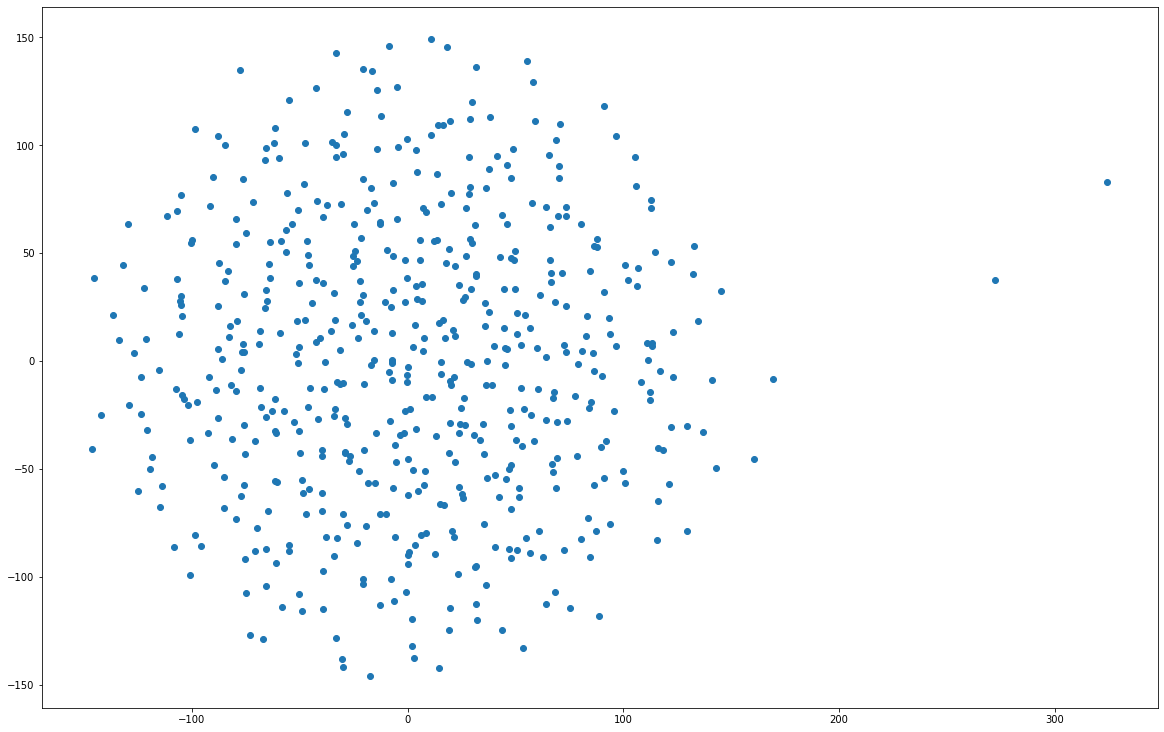

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
#"""**Apply K-means clustering on the model**"""
#Elbow Method
nc = range(1,10)
kmeans = []
score = []
kmeans = [KMeans(n_clusters = i, n_init = 100, max_iter = 500, precompute_distances = 'auto' ) for i in nc]               
score = [kmeans[i].fit(model.docvecs.doctag_syn0).score(model.docvecs.doctag_syn0) for i in range(len(kmeans))]
# Plot the elbow
plt.plot(nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

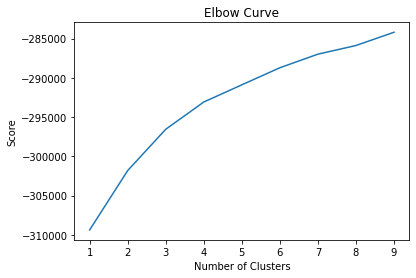

In [ ]:
K_value = 6
kmeans_model = KMeans(n_clusters = K_value, init='k-means++', n_init = 2000, max_iter = 6000, precompute_distances = 'auto')  
X = kmeans_model.fit(model.docvecs.doctag_syn0)
labels=kmeans_model.labels_.tolist()
clusters = kmeans_model.fit_predict(model.docvecs.doctag_syn0)

#PCA
l = kmeans_model.fit_predict(model.docvecs.doctag_syn0)
pca = PCA(n_components=2).fit(model.docvecs.doctag_syn0)
datapoint = pca.transform(model.docvecs.doctag_syn0)

#GRAPH
#"""**Plot the clustering result**"""

plt.figure
label1 = ["#FFFF00", "#008000", "#0000FF", "#800080", "#060080", "#80000d"]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

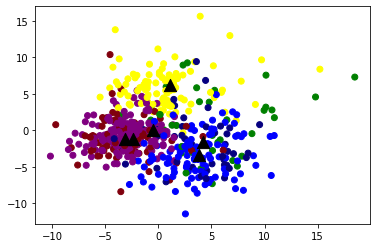

# SentBERT Embedding with K-Means
 While finding the number of clusters still is a challenge, we decided to explore BERT based embeddings for our data with the clustering algorithm.
 


In [ ]:
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import util, SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [ ]:
summary = df['summary'].to_list()
embeddeding = model.encode(summary)

In [ ]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(embedding)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.png')
plt.show()

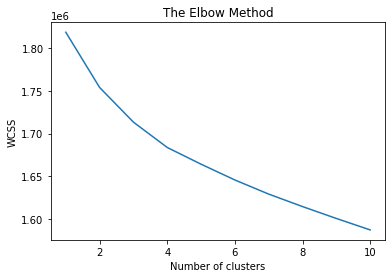

In [ ]:
### KMEANS clustering
num_clusters = 5
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(embedding)
cluster_assignment = clustering_model.labels_

clusters = [[] for _ in range(len(cluster_assignment))]
for sent_id, cluster_label in enumerate(cluster_assignment):
    clusters[cluster_label].append(embedding[sent_id])
clusters.sort(key=lambda x:len(x), reverse=True)

cnt_gourps = 0
text = ""
for c in range(len(clusters)):
    if clusters[c]:
        text += "\n" + "-"*50 + "\n"
        text += "Cluster:%d\n"%c
        text += "\n".join(str(clusters[c]))
        if len(clusters[c])>=2:
            cnt_gourps += 1 
print(cnt_gourps)

In [ ]:
with open("test_cluster.txt", "w") as f:
    f.write(text)

# Extracting Keywords
We have already tried to approach this problem using clustering and topic modeling with not much success to identify the labels/clusters. Now we decide to extract keywords to see if there's a repetitive pattern and if we can classify these keywords into classes.

In [ ]:
!pip install rake-nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from rake_nltk import Rake
rake = Rake()



df['Key_words'] = ""
df['Scores'] = ""
for index, row in df.iterrows():
    print(row)
    plot = row['cleaned_summary']

    # instantiating Rak e, by default it uses english stopwords from NLTK
    # and discards all puntuation characters as well
    r = Rake()

    # extracting the words by passing the text
    r.extract_keywords_from_text(str(plot))

    # getting the dictionary whith key words as keys and their scores as values
    key_words_dict_scores = dict(r.get_ranked_phrases_with_scores())

    # assigning the key words to the new column for the corresponding movie
    row['Key_words'] = list(key_words_dict_scores.values())
    row['Scores'] = list(key_words_dict_scores.keys())

In [ ]:
# RAKE_Summary_Keywords = []
# for text in df['cleaned_summary']:
#   rake.extract_keywords_from_text(str(text))
#   keywords = rake.get_ranked_phrases_with_scores()
#   RAKE_Summary_Keywords.append(keywords)

In [ ]:
# df['summary_keywords'] = RAKE_Summary_Keywords

In [ ]:
df.to_excel('final_output_JIRA.xlsx')

# Classification Based Approach

Upon careful analysis of the keywords, we were able to figure out some classes and thus, we saw a scope for zero-shot classification to deal with the absence of labelled data. 

In [ ]:
import pandas as pd
import re
from transformers import pipeline
from nltk import word_tokenize
from nltk.corpus import stopwords
data = pd.read_csv('Defect_Hist_Trends_01_01_22_revised.csv')
df = data[['Issue_id','Summary', 'Description']].drop_duplicates().copy()

In [ ]:
stop_words = set(stopwords.words('english'))
def preprocess(txt):
    txt = str(txt)
    txt = txt.replace('\xa0',' ').strip() # \xa0 adds space
    txt = re.sub(r'http\S+', 'URLREMOVED', txt)
    txt = re.sub(r'\d{1,2}[-\/]\d{1,2}[-\/]\d{4}|\d{4}[-\/]\d{1,2}[-\/]\d{1,2}|\d{1,2}[-\/]\d{1,2}[-\/]\d{1,2}','DATE',txt)
    txt = re.sub(r'\d{2}\:\d{2}\:{0,1}\d{0,2}','TIME', txt)
    txt = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', 'EMAILREMOVED', txt) # remove emails
    txt = re.sub(r'[-_:\/\\,\?\.]',' ', txt) # Replace with a space
    txt = txt.replace('\n',' ').replace('\t',' ').replace('\r',' ') # NOTE: Hope it doeesn't affect txts like url\new
    txt = txt.replace('!',' ').replace('~','').replace('`','')
    txt = re.sub(r'\'t|\'s|’t|’s', '', txt) # remove 's 't
    txt = re.sub(r'[\{\}\[\]\(\)<>\'\"\*”’$;#%^@|=+-]',' ', txt) # Remove
    txt = re.sub(r'[A-Z][a-z]+',lambda x: x.group(0).lower(), txt) # Selective lowercase : https://stackoverflow.com/a/7588961/15505495
    txt = re.sub(r'\d', '', txt) # Remove numbers
    txt = re.sub(r' +',' ',txt) # Remove multiple white spaces
    # Stopword removal
    tokenized = word_tokenize(txt)
    txt = ' '.join([w for w in tokenized if w not in stop_words]) # Stopword removal  
    return txt.strip()

In [ ]:
df['cleaned_summary'] = df.Summary.apply(preprocess) 
df = df.drop(columns=['Summary', 'Description'])

In [ ]:
df.to_csv('zero_shot_input.csv', index=False) # Null in summary will be having 'nan' as value

# Zero Shot

In [ ]:
classifier = pipeline("zero-shot-classification", device=0)
candidate_labels = ["QA Automation API",
"Uploading Documents",
"Missing Values",
"Anti-virus software",
"DMS",
"New Window Issues",
"Smoke Test",
"NRT",
"Nexus",
"Data",
"Dev Stage Server",
"NWCC",
"WICS",
"Bug",
"Modals",
"DCS",
"Regression Test",
"Validation Test",
"Web Service"
]


No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)


Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
df = pd.read_csv('zero_shot_input.csv')
df.shape

(6196, 3)

In [ ]:
%%time
df['class'] = df['cleaned_summary'].apply(lambda x: classifier(str(x), candidate_labels))
print('Generated Classes')

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1015: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


Generated Classes
CPU times: user 42min 5s, sys: 32.7 s, total: 42min 38s
Wall time: 42min 37s


In [ ]:
label = []
for i in df['class']:
  label.append(i["labels"][0])

df['label'] = label
print('Saved Labels to the file')

df.to_csv('final_classified.csv')

Saved Labels to the file


# Exploration of the output

In [ ]:
import pandas as pd
df = pd.read_csv('final_classified.csv')

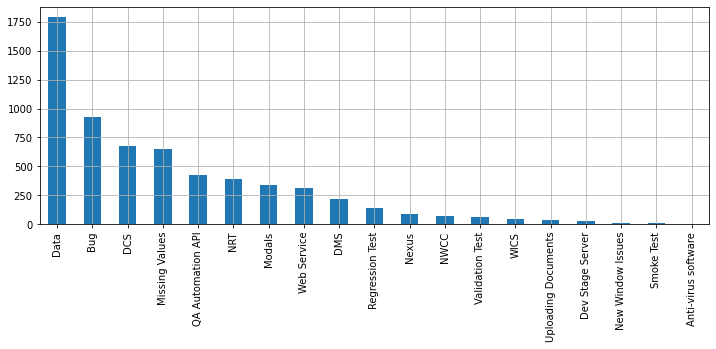

In [ ]:
vc = df.label.value_counts()
vc.plot(kind='bar', figsize = (12,4), grid=True)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

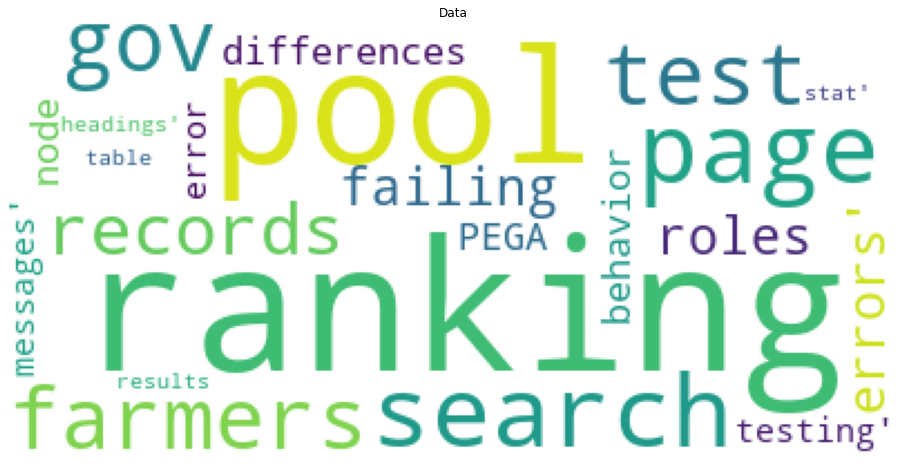

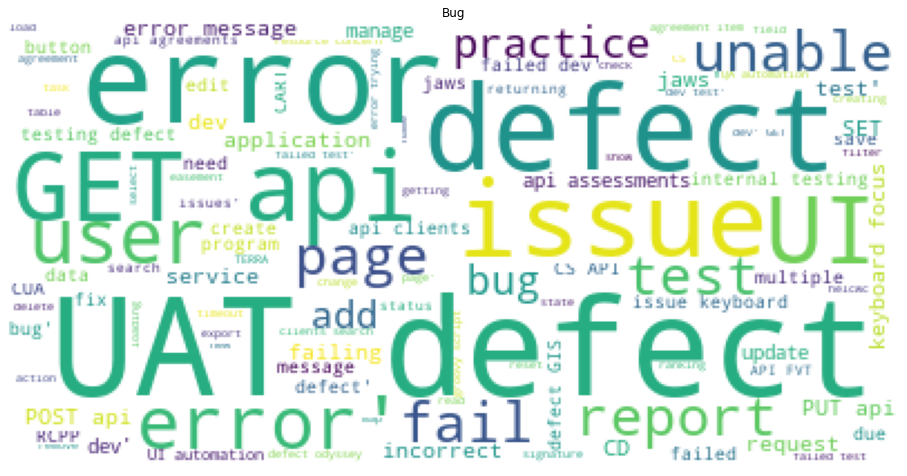

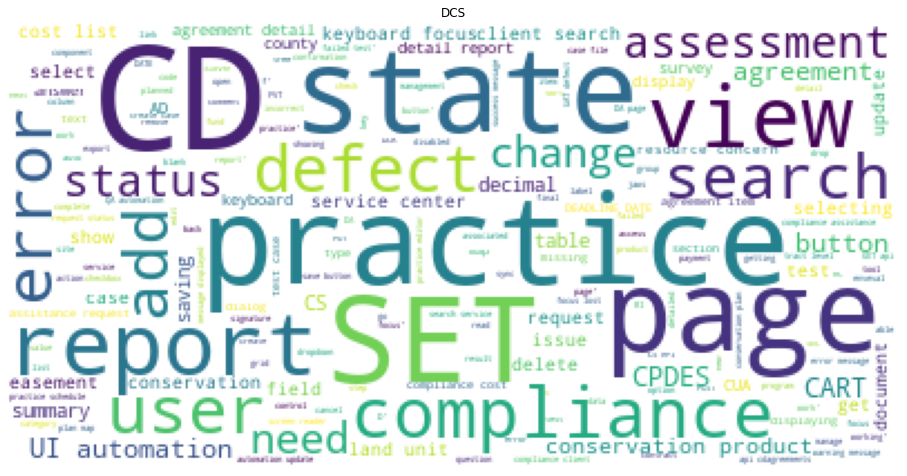

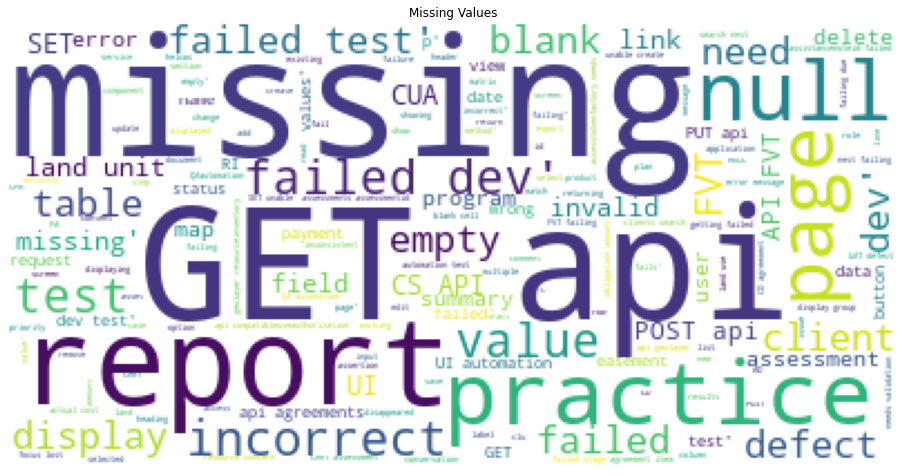

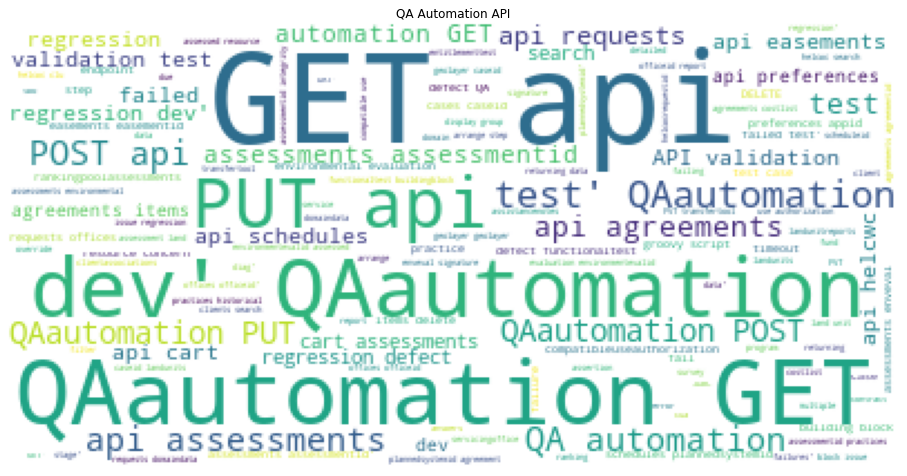

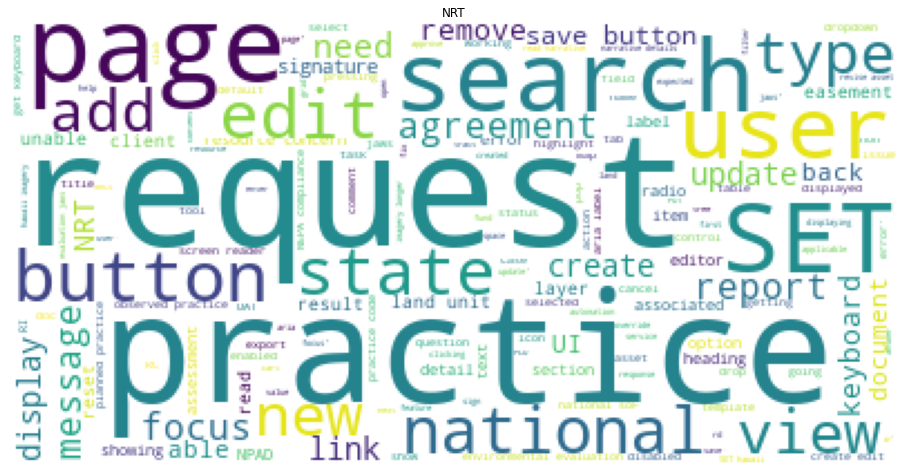

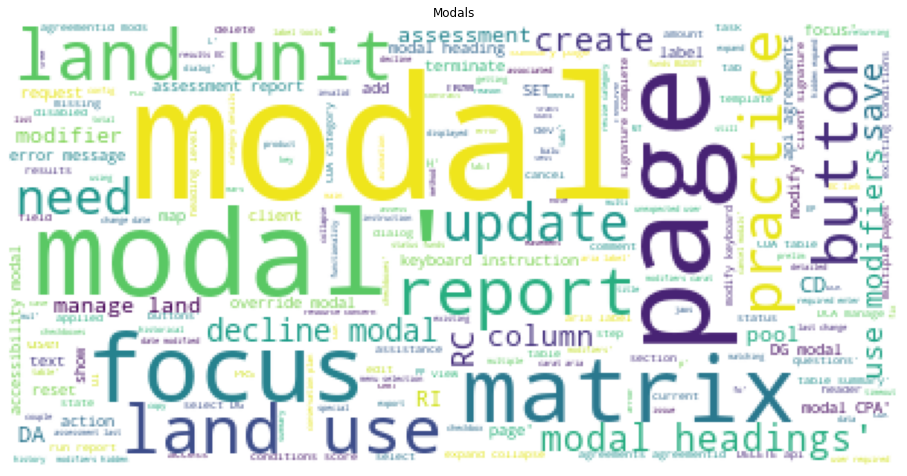

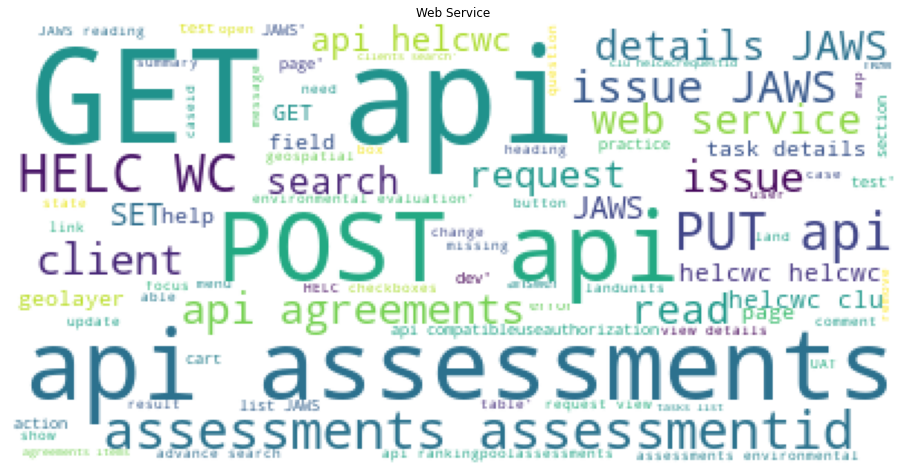

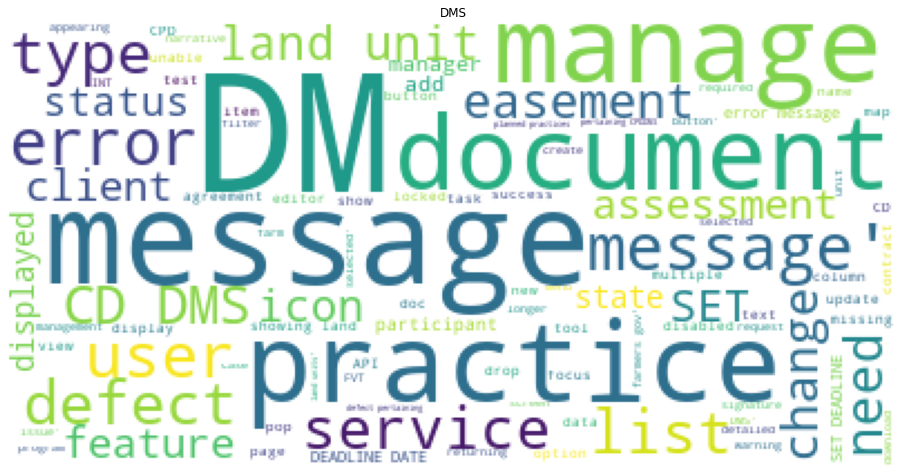

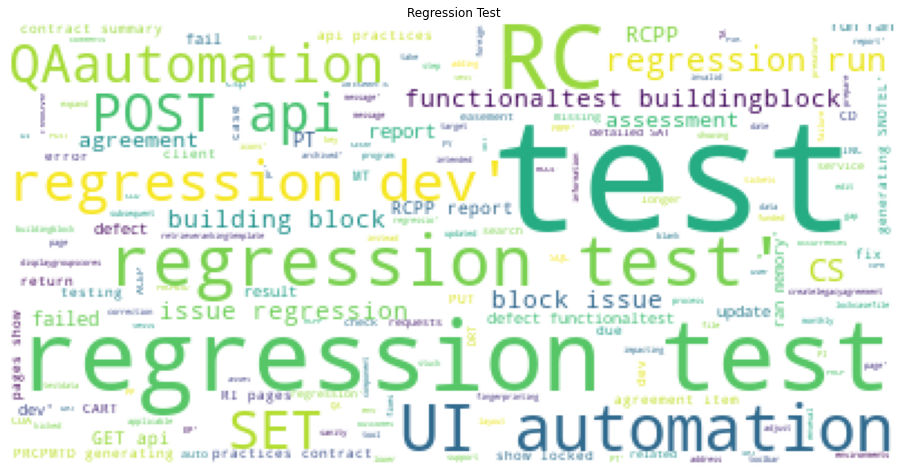

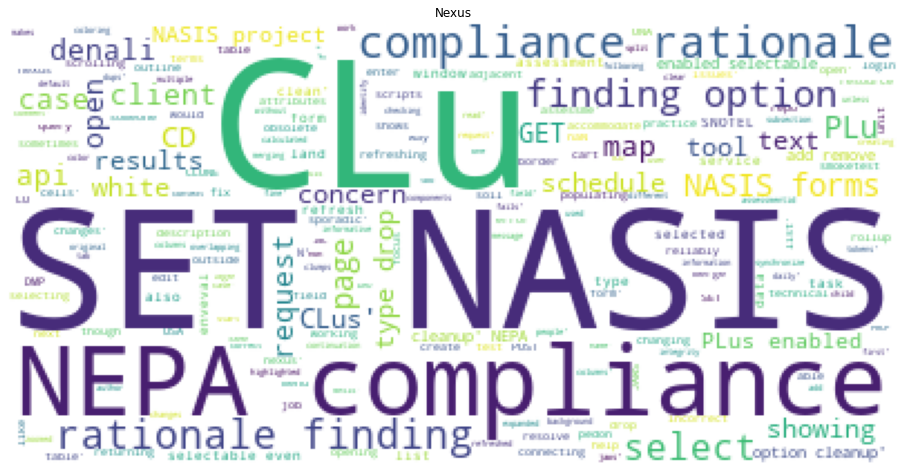

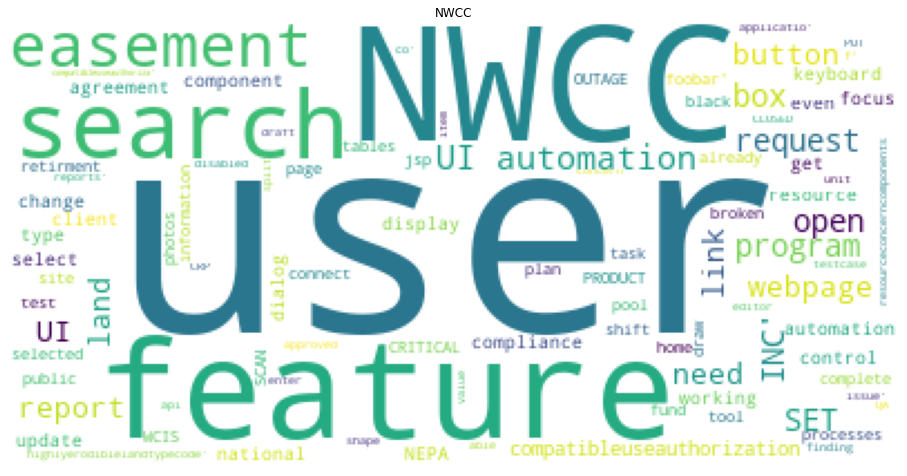

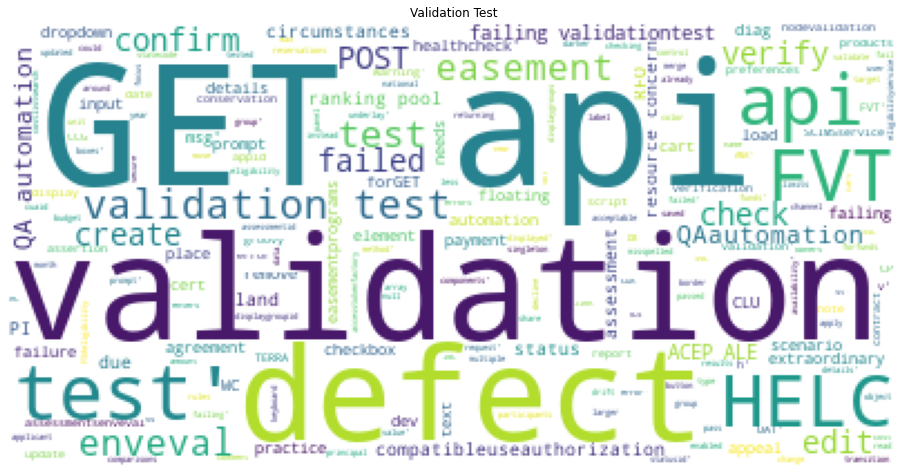

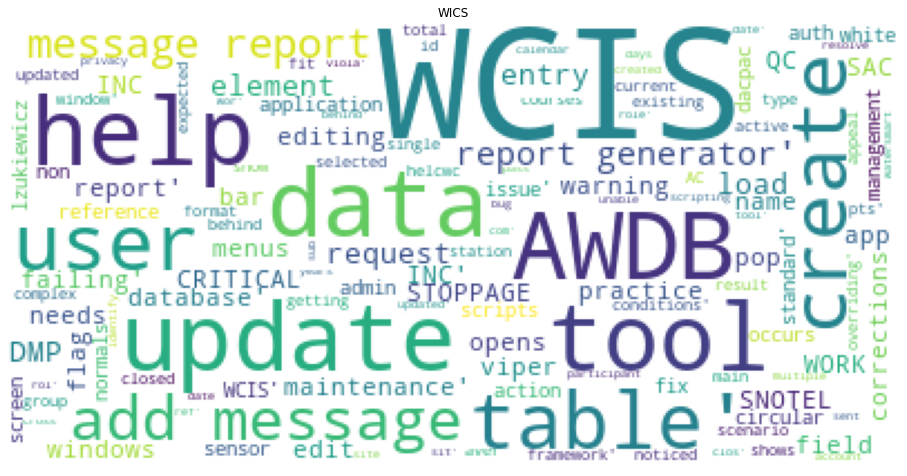

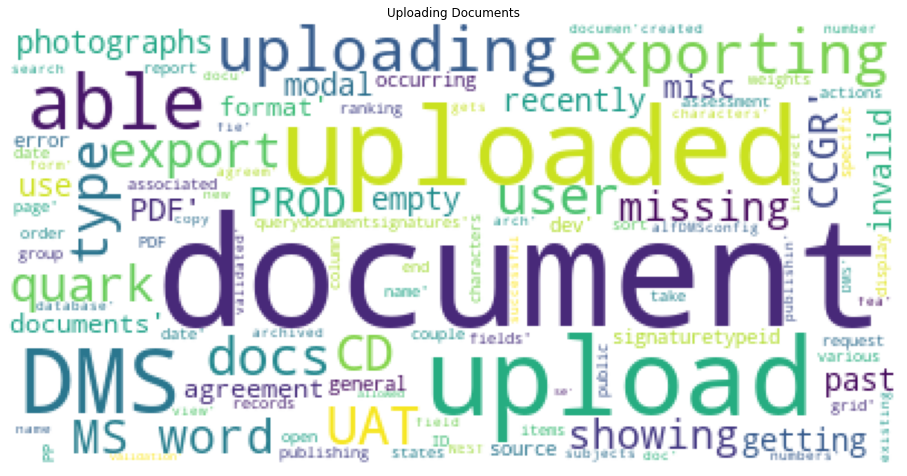

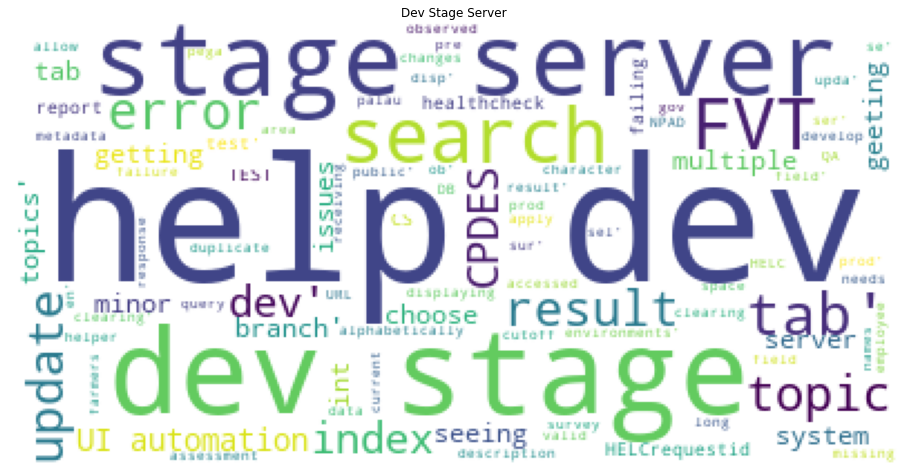

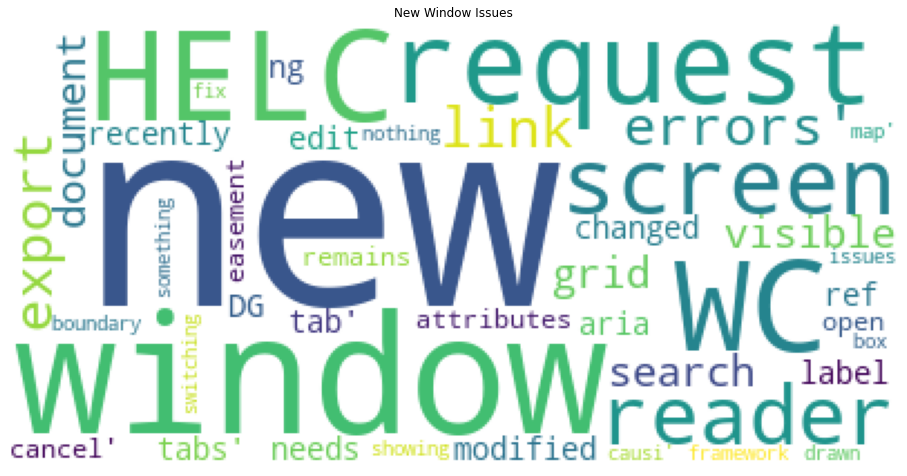

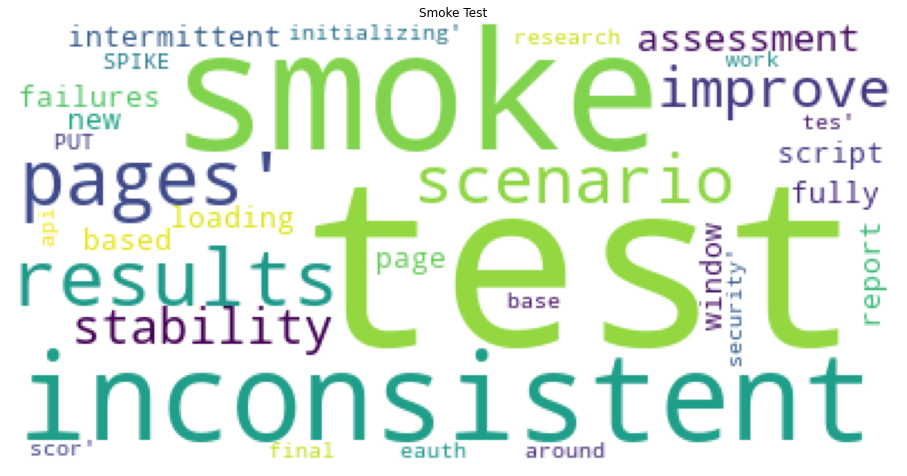

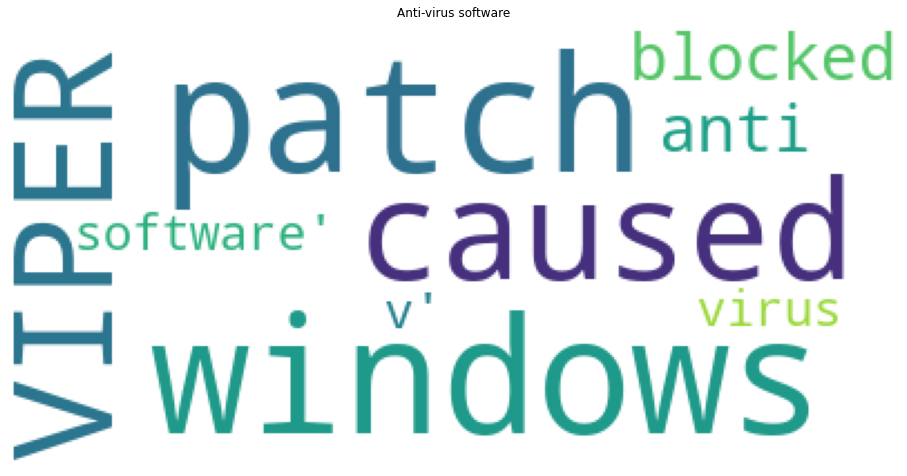

In [ ]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
SW = set(stopwords.words('english')) #.union({'GET','api'})
for label in vc.keys():
    wc = WordCloud(background_color="white", stopwords=SW).generate(str(df[df.label == label]['cleaned_summary'].values))
    plt.figure(figsize=(16,9))
    plt.title(label)
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    print()